In [1]:
import xml.etree.ElementTree as et
import shutil
import yaml
from pathlib import Path
from ultralytics import YOLO
from IPython.display import Image

def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    w, h = box[2] - box[0], box[3] - box[1]
    x, y = box[0] + w / 2, box[1] + h / 2
    return x * dw, y * dh, w * dw, h * dh
 
def VOC_to_YOLO(ann, img, split_dir):
    tree = et.parse(ann)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    with open((split_dir / 'labels' / ann.stem).with_suffix('.txt'), 'w') as out_file:
        for obj in root.iter('object'):
            cls_name = obj.find('name').text.lower()
            if cls_name in classes:
                bndbox = obj.find('bndbox')
                newbox = convert_box((w, h), [int(float(bndbox.find(crd).text)) for crd in ('xmin', 'ymin', 'xmax', 'ymax')])
                out_file.write(f"{classes.index(cls_name)} {' '.join(map(str, newbox))}\n")
            elif cls_name not in ignored_cls:
                ignored_cls.append(cls_name)
    shutil.move(img, split_dir / 'images' / img.name)

def YOLO_to_YOLO(in_file, out_file, old_cls):
    converted = []
    with open(in_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        words = line.split()
        if words:
            cls_name = old_cls[int(words[0])].lower()
            if cls_name in classes:
                words[0] = str(classes.index(cls_name))
                converted.append(' '.join(words))
            elif cls_name not in ignored_cls:
                ignored_cls.append(cls_name)
    with open(out_file, 'w') as f:
        for line in converted:
            f.write(f"{line}\n")

def unpack_data(data):
    ds_path = []
    for zip in data.glob('*.zip'):
        ds_path.append(data / zip.stem)
        if ds_path[-1].exists():
            shutil.rmtree(ds_path[-1])
        shutil.unpack_archive(zip, ds_path[-1])
    return ds_path

def create_dirs(split_dirs):
    for path in split_dirs:
        if path.exists():
            shutil.rmtree(path)
        (path / 'images').mkdir(parents=True)
        (path / 'labels').mkdir(parents=True)

def process_VOC_ds(path, split_dirs):
    path_img = path if not (path / 'images').is_dir() else path / 'images'
    anns = list((path / 'annotations').rglob('*.*'))
    tenth = len(anns) / 10
    for i, ann in enumerate(anns): # 80% / 10% / 10% split
        img = list(path_img.glob(f"{ann.stem}.*"))
        if i < tenth * 8:
            VOC_to_YOLO(ann, img[0], split_dirs[0])
        elif i < tenth * 9:
            VOC_to_YOLO(ann, img[0], split_dirs[1])
        else:
            VOC_to_YOLO(ann, img[0], split_dirs[2])

def process_YOLO_ds(path, data):
    with open(path / 'data.yaml', 'r') as f:
        info = yaml.safe_load(f)
    ds_cls = info['names']
    for subdir in path.iterdir():
        if subdir.is_dir():
            for file in subdir.rglob('*.*'):
                out_file = data / file.parts[-3] / file.parts[-2] / file.name
                if file.suffix == '.txt':
                    YOLO_to_YOLO(file, out_file, ds_cls)
                else:
                    shutil.move(file, out_file)

classes = ['helmet','gloves','goggles','gas_mask','coverall']
ignored_cls = []
cwd = Path.cwd()
data = cwd / 'datasets'
ds_path = unpack_data(data)
split_dirs = data / 'train', data / 'valid', data / 'test'
create_dirs(split_dirs)

for path in ds_path:
    if (path / 'data.yaml').exists():
        process_YOLO_ds(path, data)
    else:
        process_VOC_ds(path, split_dirs)
    shutil.rmtree(path)

config = {
   'train': str(split_dirs[0] / 'images'),
   'val': str(split_dirs[1] / 'images'),
   'test': str(split_dirs[2] / 'images'),
   'nc': len(classes),
   'names': classes
}
with open(data / 'data.yaml', 'w') as file:
    yaml.dump(config, file)

train = len(list((split_dirs[0] / 'images').glob('*')))
val = len(list((split_dirs[1] / 'images').glob('*')))
test = len(list((split_dirs[2] / 'images').glob('*')))
total = train + val + test
print(f"Train set: {train:11d} {train / total:8.2%}\n"
      f"Validation set: {val:6d} {val / total:8.2%}\n"
      f"Test set: {test:12d} {test / total:8.2%}\n"
      f"Total: {total:15d}")
if ignored_cls:
    print("Ignored classes:", ignored_cls)

Train set:       25363   78.39%
Validation set:   4313   13.33%
Test set:         2677    8.27%
Total:           32353
Ignored classes: ['no_helmet', 'no_mask', 'mask', 'no_goggles', 'shoes', 'no_shoes', 'no_gloves', 'suit', 'no-suit', 'face_shield', 'head', 'person']


In [3]:
model = YOLO('yolov8n.pt')
graph = cwd / 'runs/detect/train'
if graph.is_dir():
    shutil.rmtree(graph)
results = model.train(data=data / 'data.yaml', imgsz=640, batch=32, epochs=20, save_dir=graph, #focal loss, albumination, backgrounds
                      deterministic=False, half=True, workers=8, workspace=6)

Ultralytics YOLOv8.2.28  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=d:\Repos\ProtectionDetection\datasets\data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=False, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning D:\Repos\ProtectionDetection\datasets\train\labels.cache... 25363 images, 7552 backgrounds, 0 corrupt: 100%|██████████| 25363/25363 [00:00<?, ?it/s]
val: Scanning D:\Repos\ProtectionDetection\datasets\valid\labels.cache... 4313 images, 1814 backgrounds, 0 corrupt: 100%|██████████| 4313/4313 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.45G      1.729      2.208      1.343         32        640: 100%|██████████| 793/793 [03:34<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.29it/s]

                   all       4313       5579       0.72      0.444      0.522      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.29G      1.625      1.163      1.286         28        640: 100%|██████████| 793/793 [03:26<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.38it/s]

                   all       4313       5579       0.61      0.544      0.572      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.27G      1.606      1.061      1.277         36        640: 100%|██████████| 793/793 [03:24<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.38it/s]

                   all       4313       5579      0.788      0.509      0.588      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.29G      1.584      1.015      1.279         59        640: 100%|██████████| 793/793 [03:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.50it/s]

                   all       4313       5579      0.689      0.595       0.65      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.37G      1.546     0.9529      1.257         42        640: 100%|██████████| 793/793 [03:19<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.37it/s]


                   all       4313       5579      0.768      0.556      0.656       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.29G      1.523     0.9057      1.243         44        640: 100%|██████████| 793/793 [03:20<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.46it/s]

                   all       4313       5579      0.748      0.645        0.7      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.31G      1.503     0.8774      1.228         43        640: 100%|██████████| 793/793 [03:21<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.51it/s]

                   all       4313       5579      0.794      0.606      0.703      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.32G      1.487     0.8505      1.223         35        640: 100%|██████████| 793/793 [03:21<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.43it/s]

                   all       4313       5579      0.768      0.638      0.696      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.56G      1.466     0.8203      1.208         42        640: 100%|██████████| 793/793 [03:24<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.37it/s]

                   all       4313       5579      0.773      0.632      0.715      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.32G      1.458     0.8009      1.204         33        640: 100%|██████████| 793/793 [03:24<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.37it/s]

                   all       4313       5579      0.794      0.692      0.756       0.43


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.44G      1.439     0.7287      1.241         27        640: 100%|██████████| 793/793 [03:41<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:22<00:00,  3.04it/s]

                   all       4313       5579      0.806      0.676      0.747       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.28G      1.429     0.7043      1.232         25        640: 100%|██████████| 793/793 [03:23<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.40it/s]

                   all       4313       5579      0.805      0.684      0.748      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.27G      1.407     0.6821      1.221         33        640: 100%|██████████| 793/793 [03:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.46it/s]

                   all       4313       5579      0.815      0.681      0.757      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.28G      1.392     0.6638      1.212         35        640: 100%|██████████| 793/793 [03:20<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.47it/s]

                   all       4313       5579      0.833      0.707      0.774      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.27G      1.375     0.6456      1.205         30        640: 100%|██████████| 793/793 [03:17<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.48it/s]

                   all       4313       5579      0.793      0.689      0.766      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.28G      1.361     0.6316      1.194         28        640: 100%|██████████| 793/793 [03:19<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.49it/s]

                   all       4313       5579       0.81      0.695      0.765       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.27G      1.339     0.6166      1.184         29        640: 100%|██████████| 793/793 [03:21<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.49it/s]

                   all       4313       5579      0.858      0.696      0.777      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.45G      1.323      0.599      1.176         30        640: 100%|██████████| 793/793 [03:21<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.50it/s]

                   all       4313       5579      0.867       0.69      0.788      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.27G      1.306     0.5865      1.168         30        640: 100%|██████████| 793/793 [03:20<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.50it/s]

                   all       4313       5579       0.85       0.71      0.786      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.32G      1.292     0.5737      1.159         34        640: 100%|██████████| 793/793 [03:20<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.52it/s]

                   all       4313       5579      0.878      0.694      0.786      0.478



20 epochs completed in 1.249 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.28  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:20<00:00,  3.33it/s]


                   all       4313       5579      0.878      0.695      0.786      0.477
                helmet        698       2269      0.896      0.871      0.918      0.543
                gloves        684       1455      0.881      0.772      0.871      0.486
               goggles       1285       1359      0.848      0.626      0.717      0.427
              gas_mask        185        189      0.801      0.836      0.883      0.603
              coverall        235        307      0.966      0.368      0.542      0.327
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train


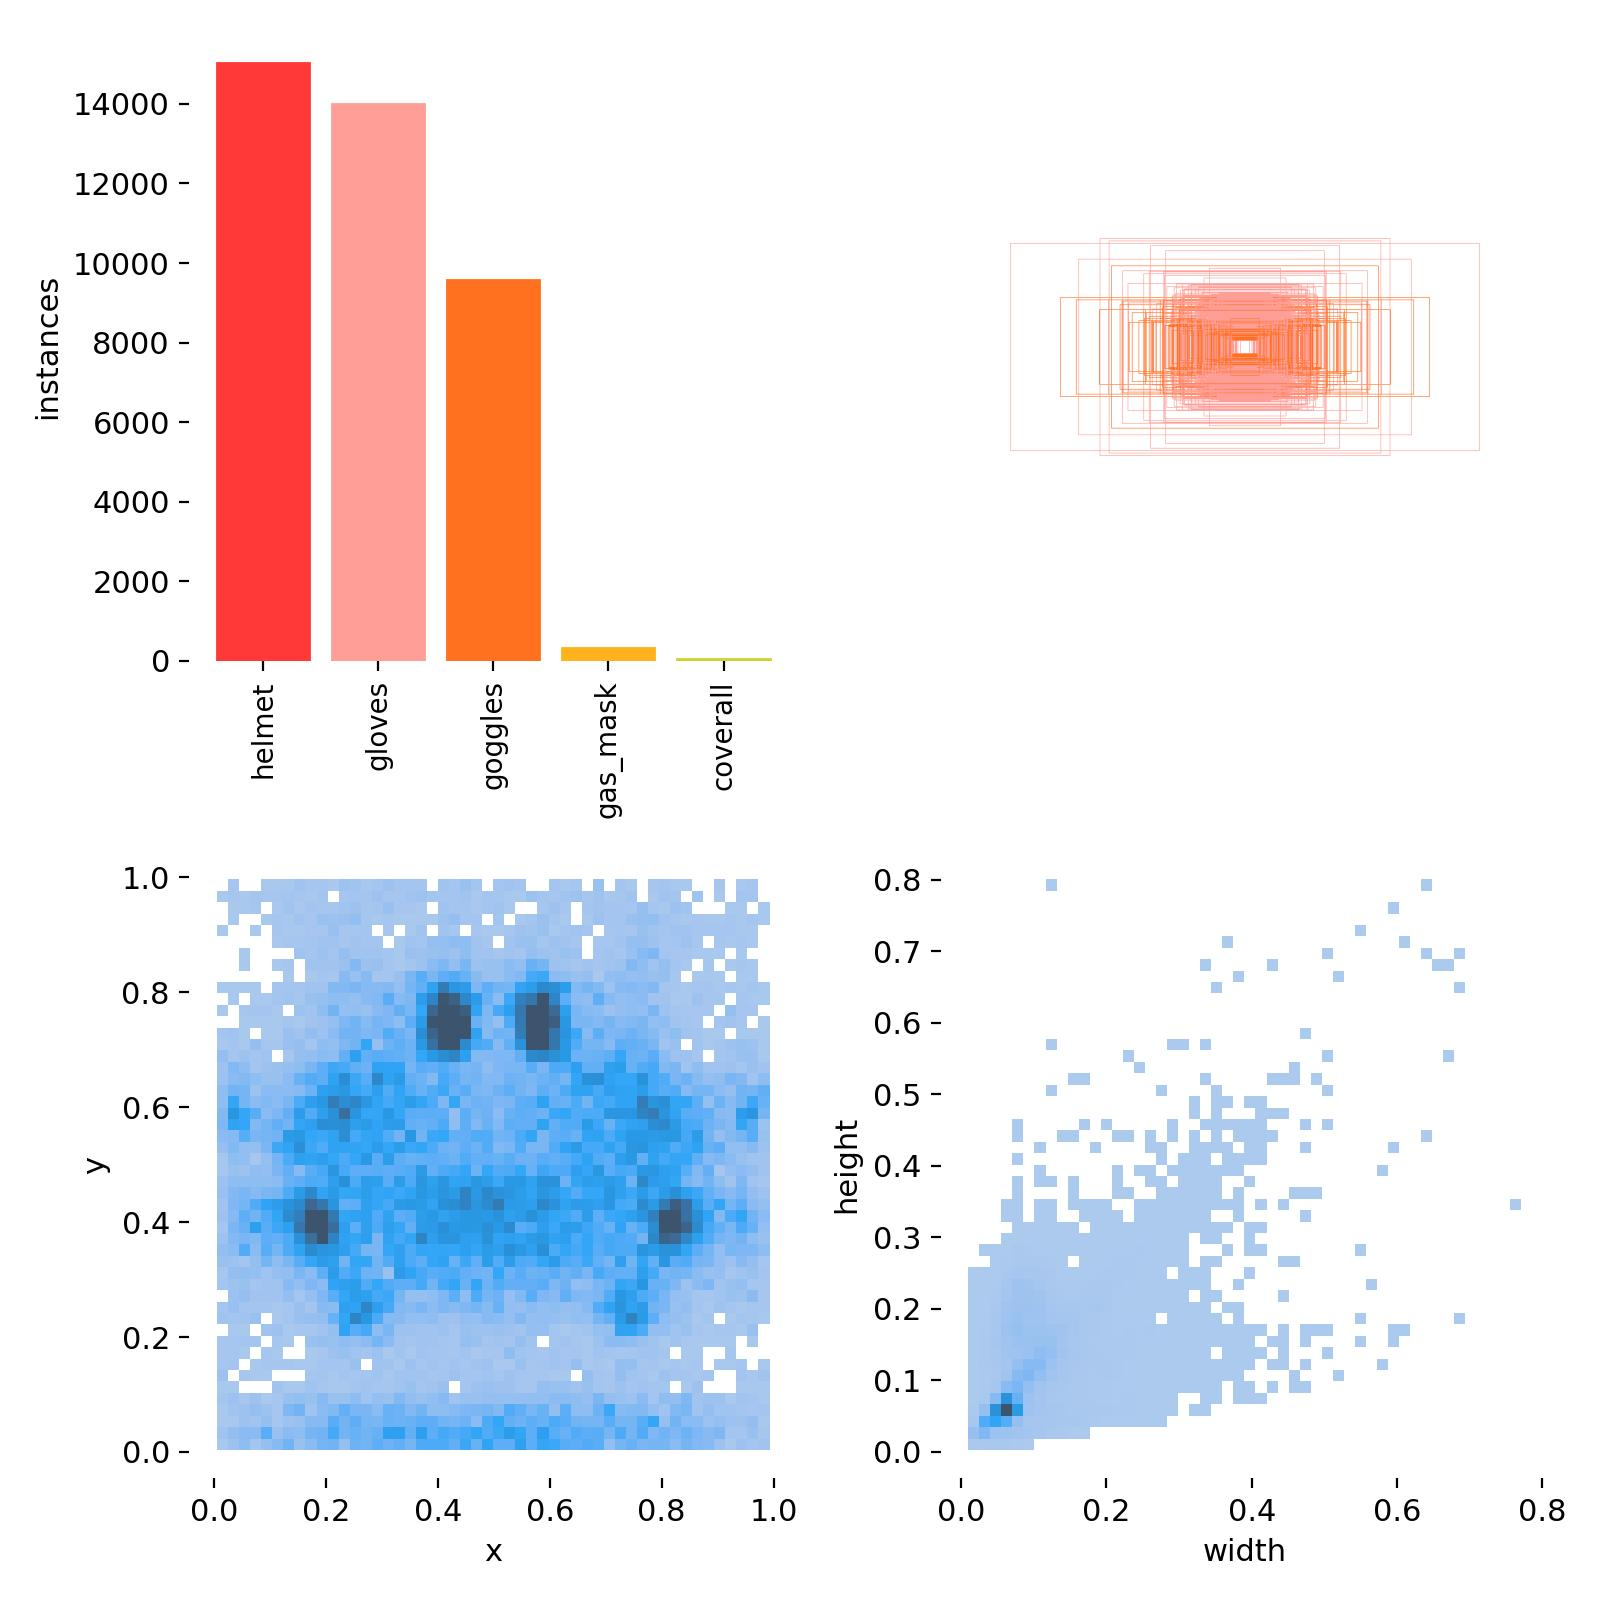

In [9]:
Image(filename=graph / 'labels.jpg', width=800)

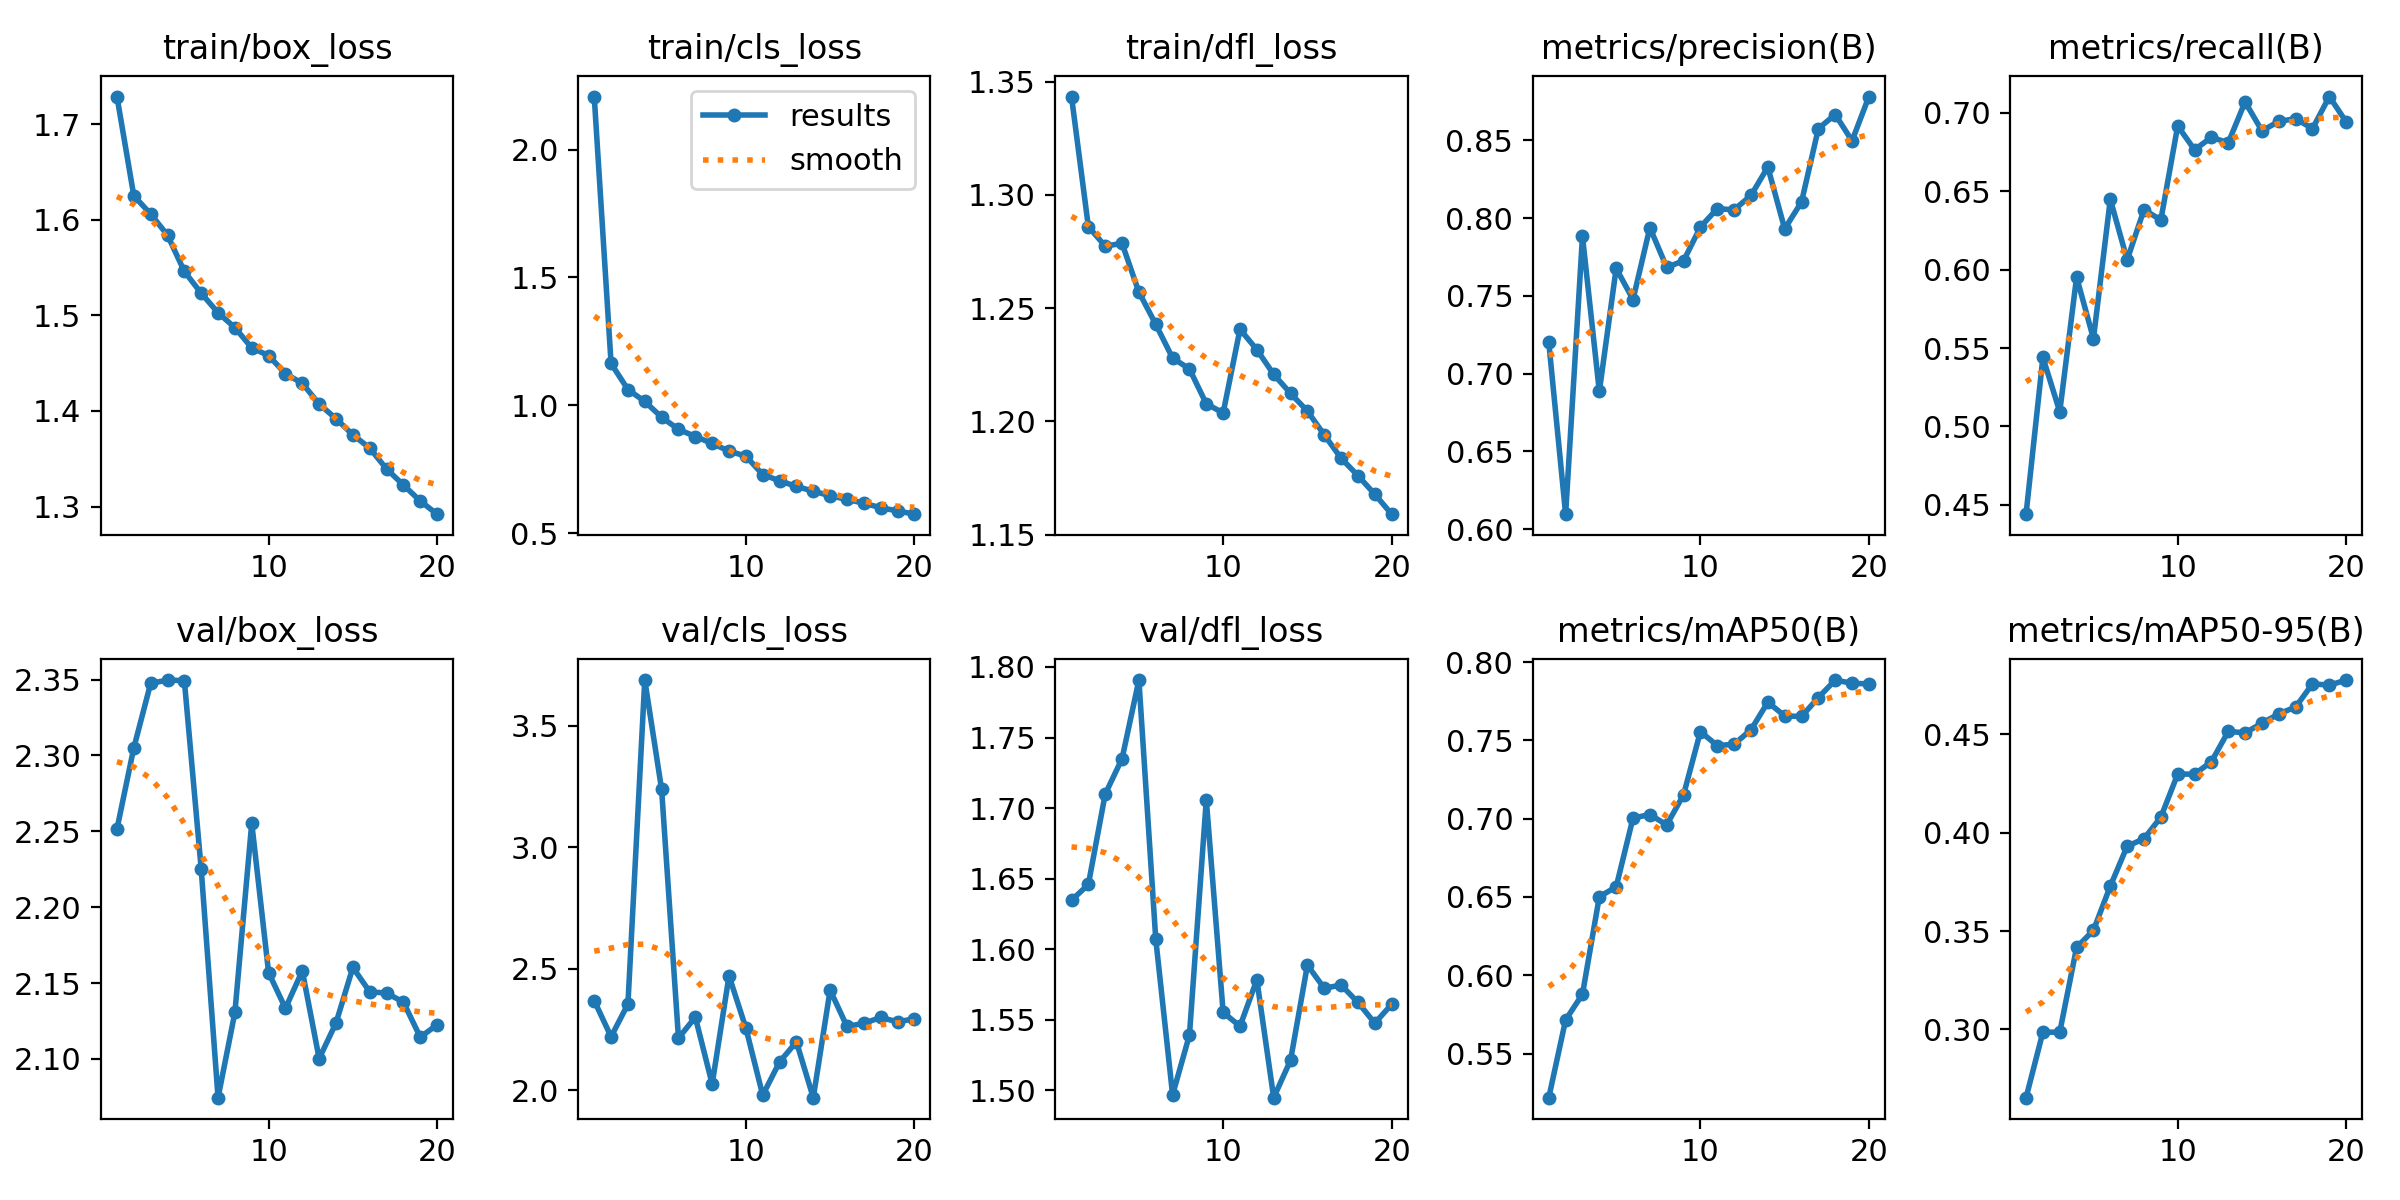

In [7]:
Image(filename=graph / 'results.png', width=1400)

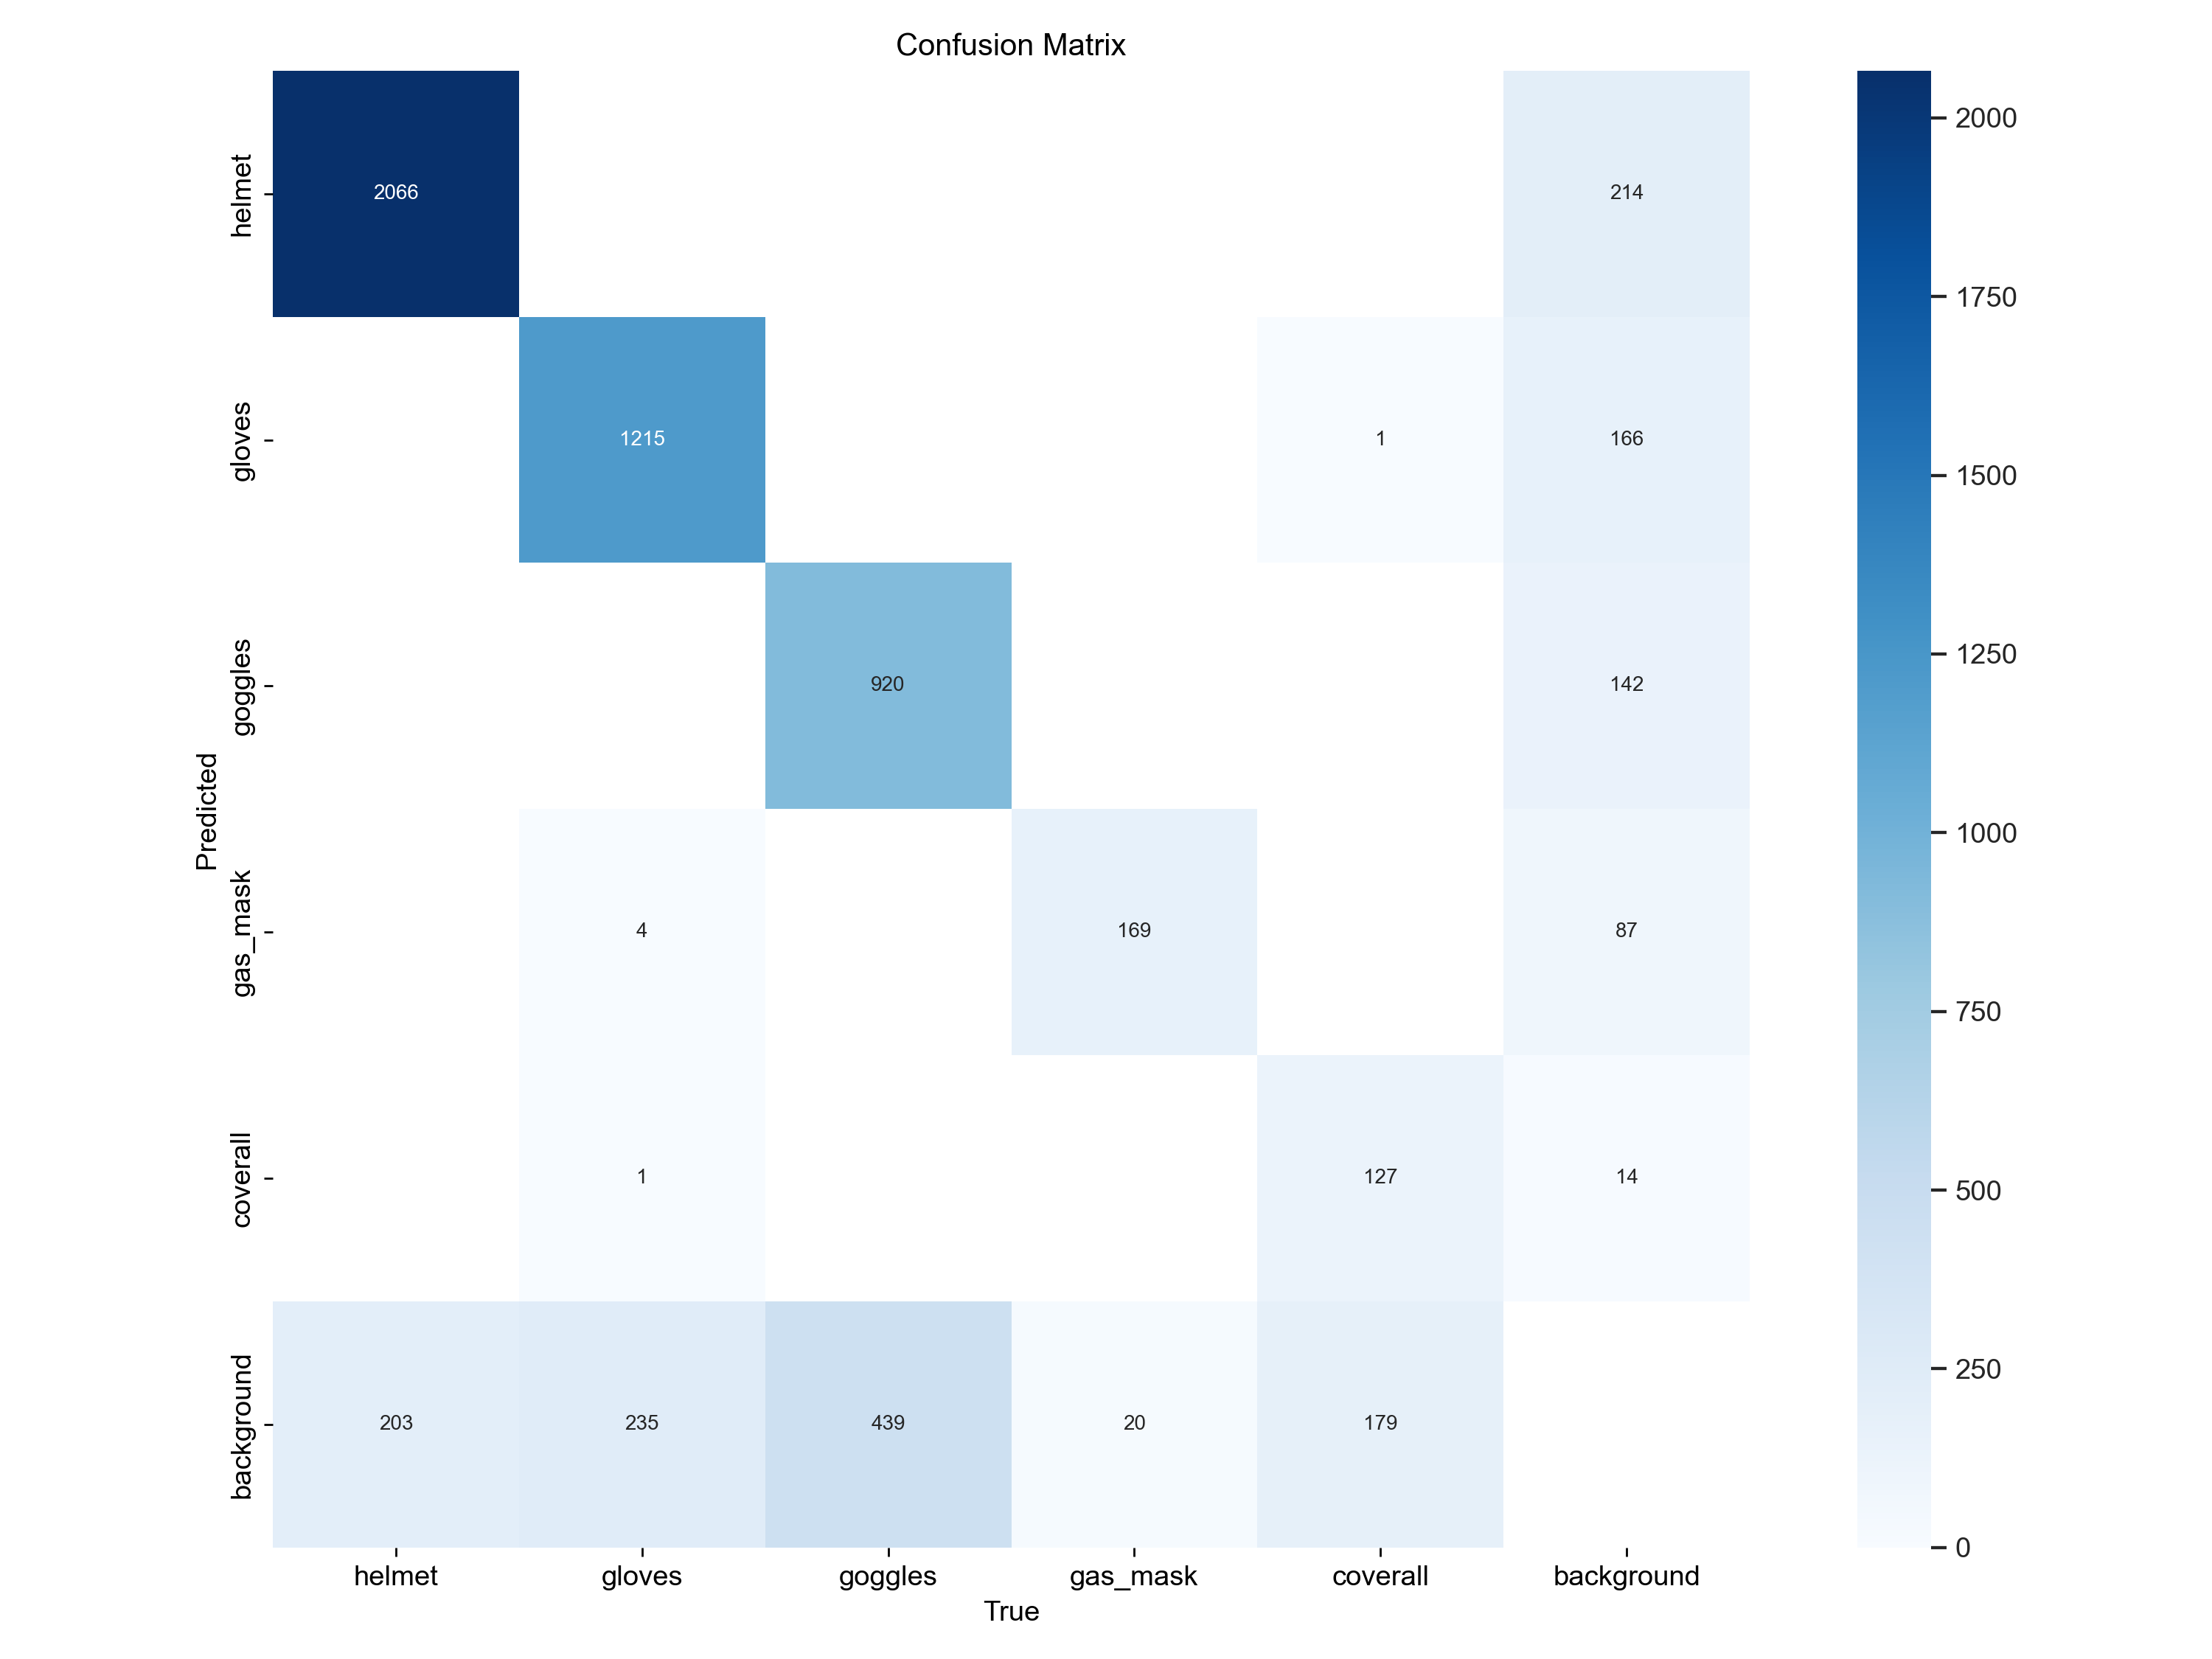

In [6]:
Image(filename=graph / 'confusion_matrix.png', width=800)

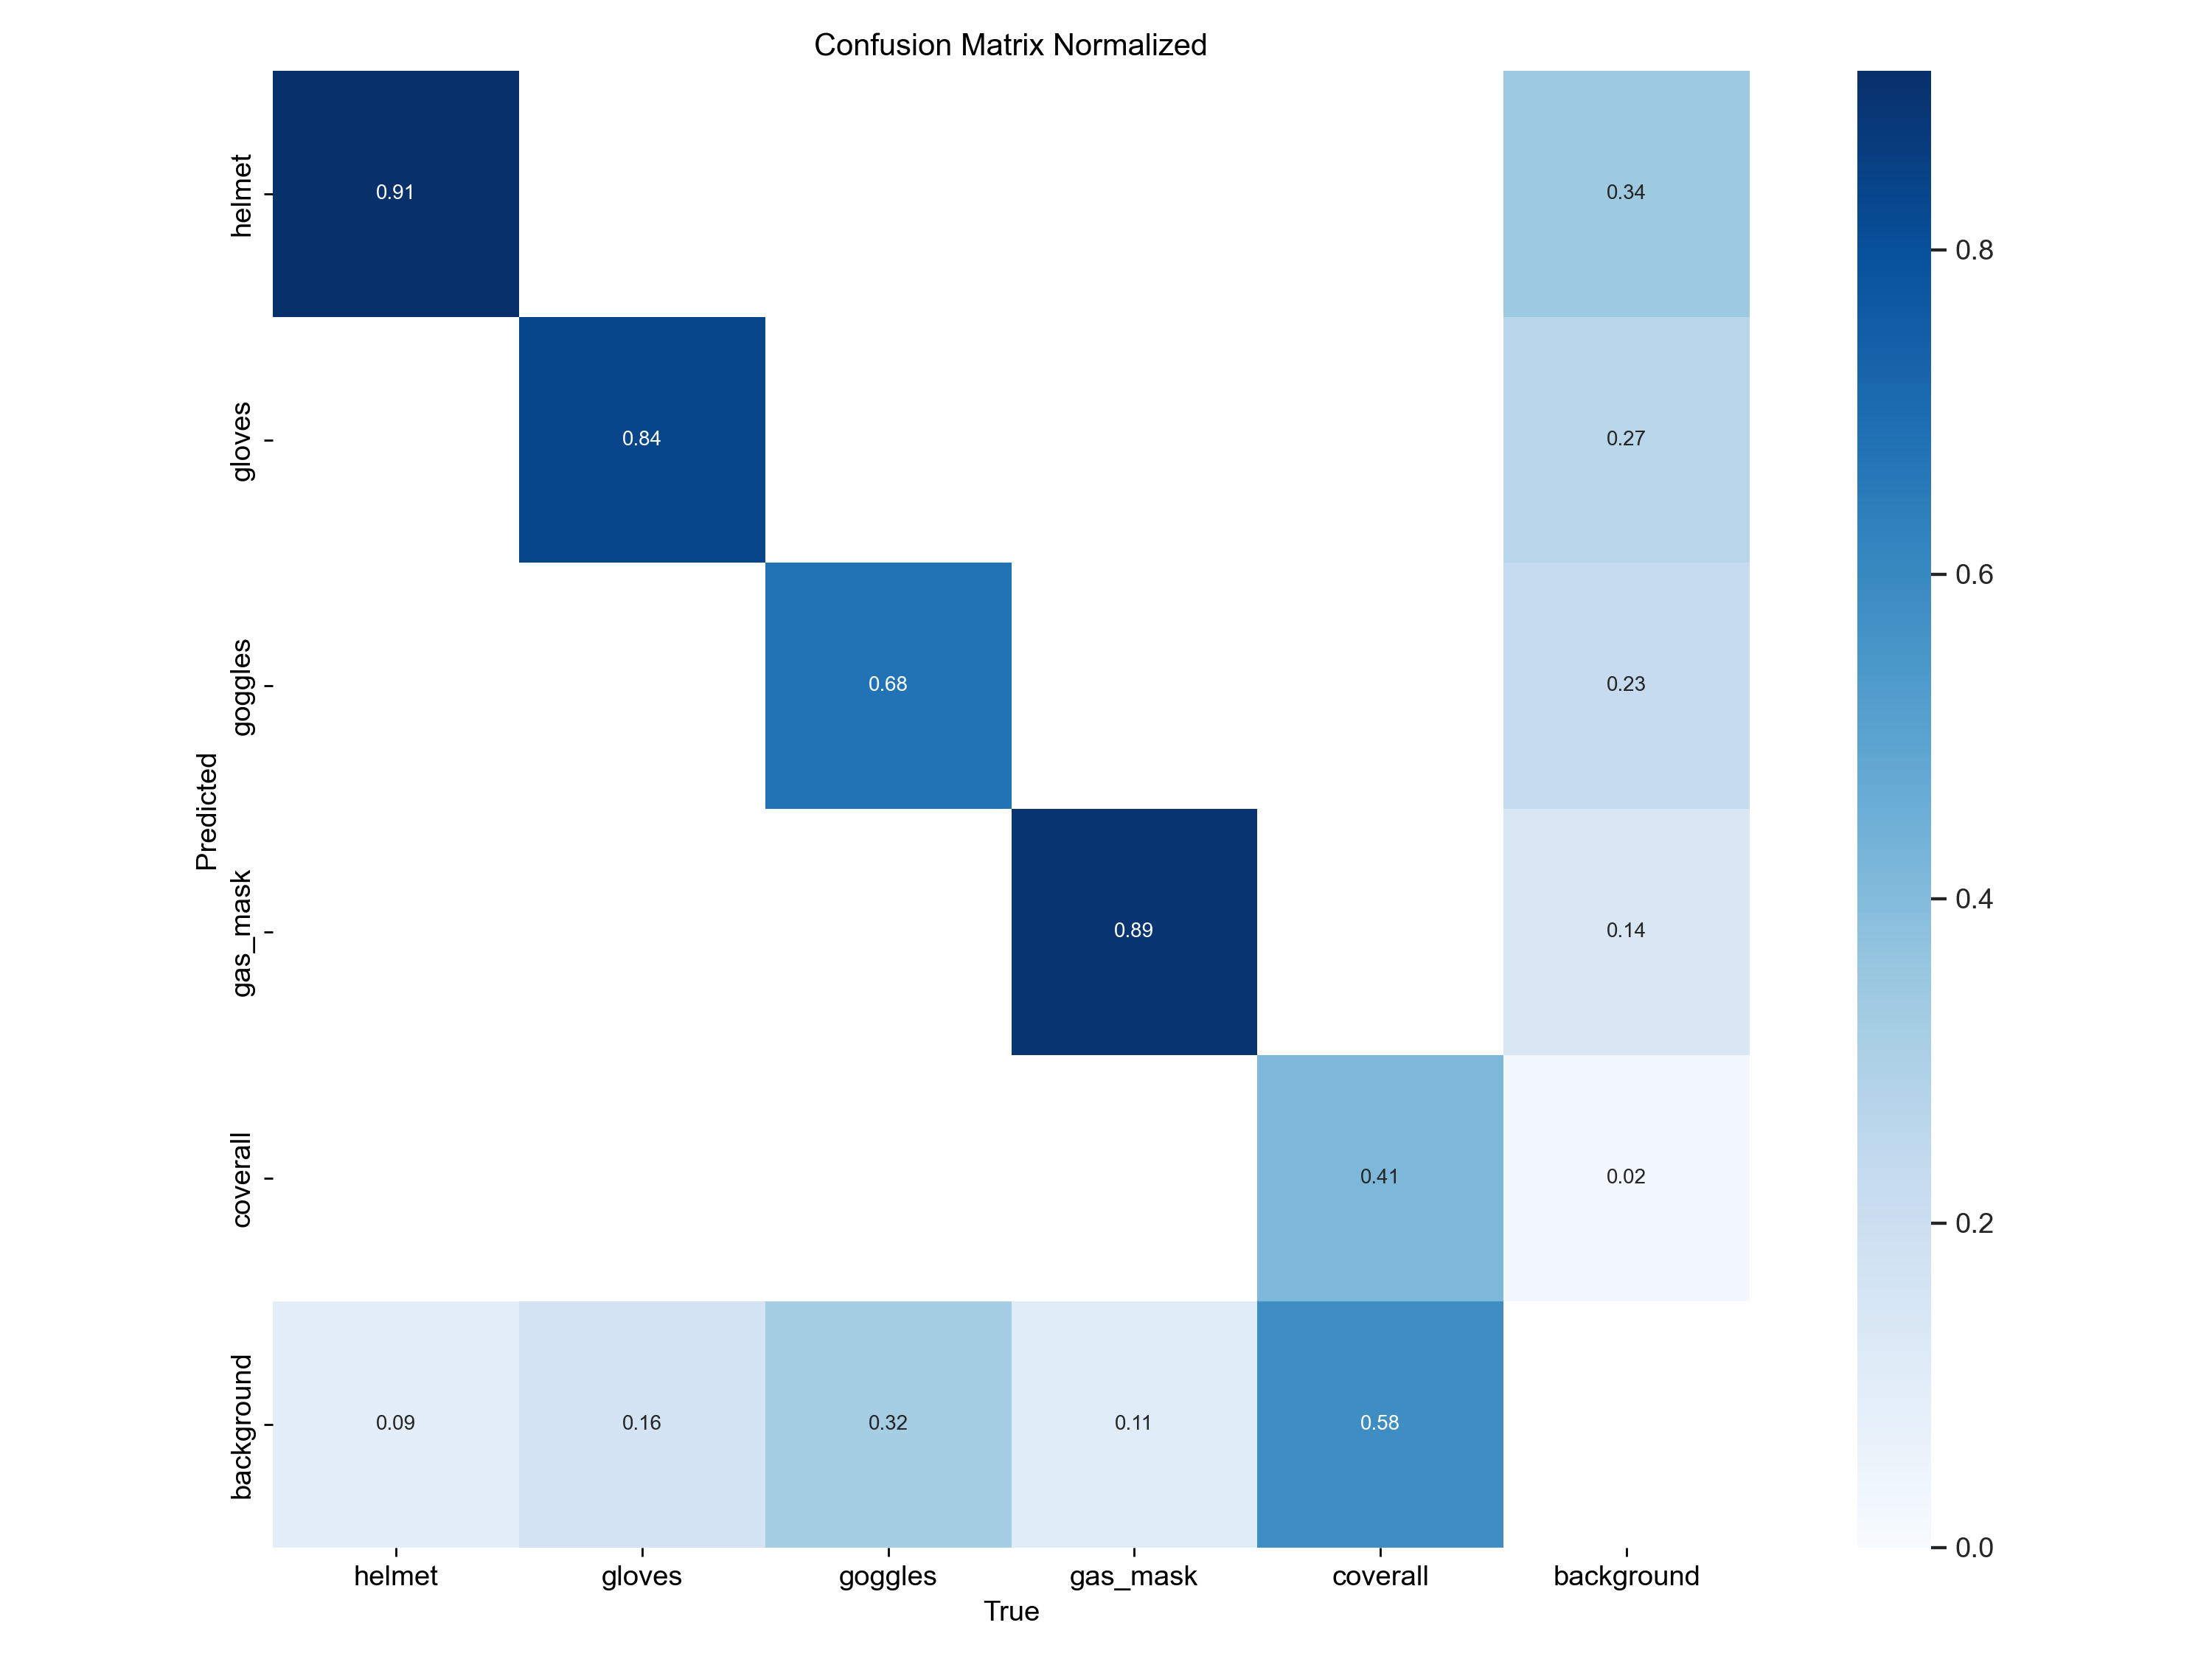

In [7]:
Image(filename=graph / 'confusion_matrix_normalized.png', width=800)

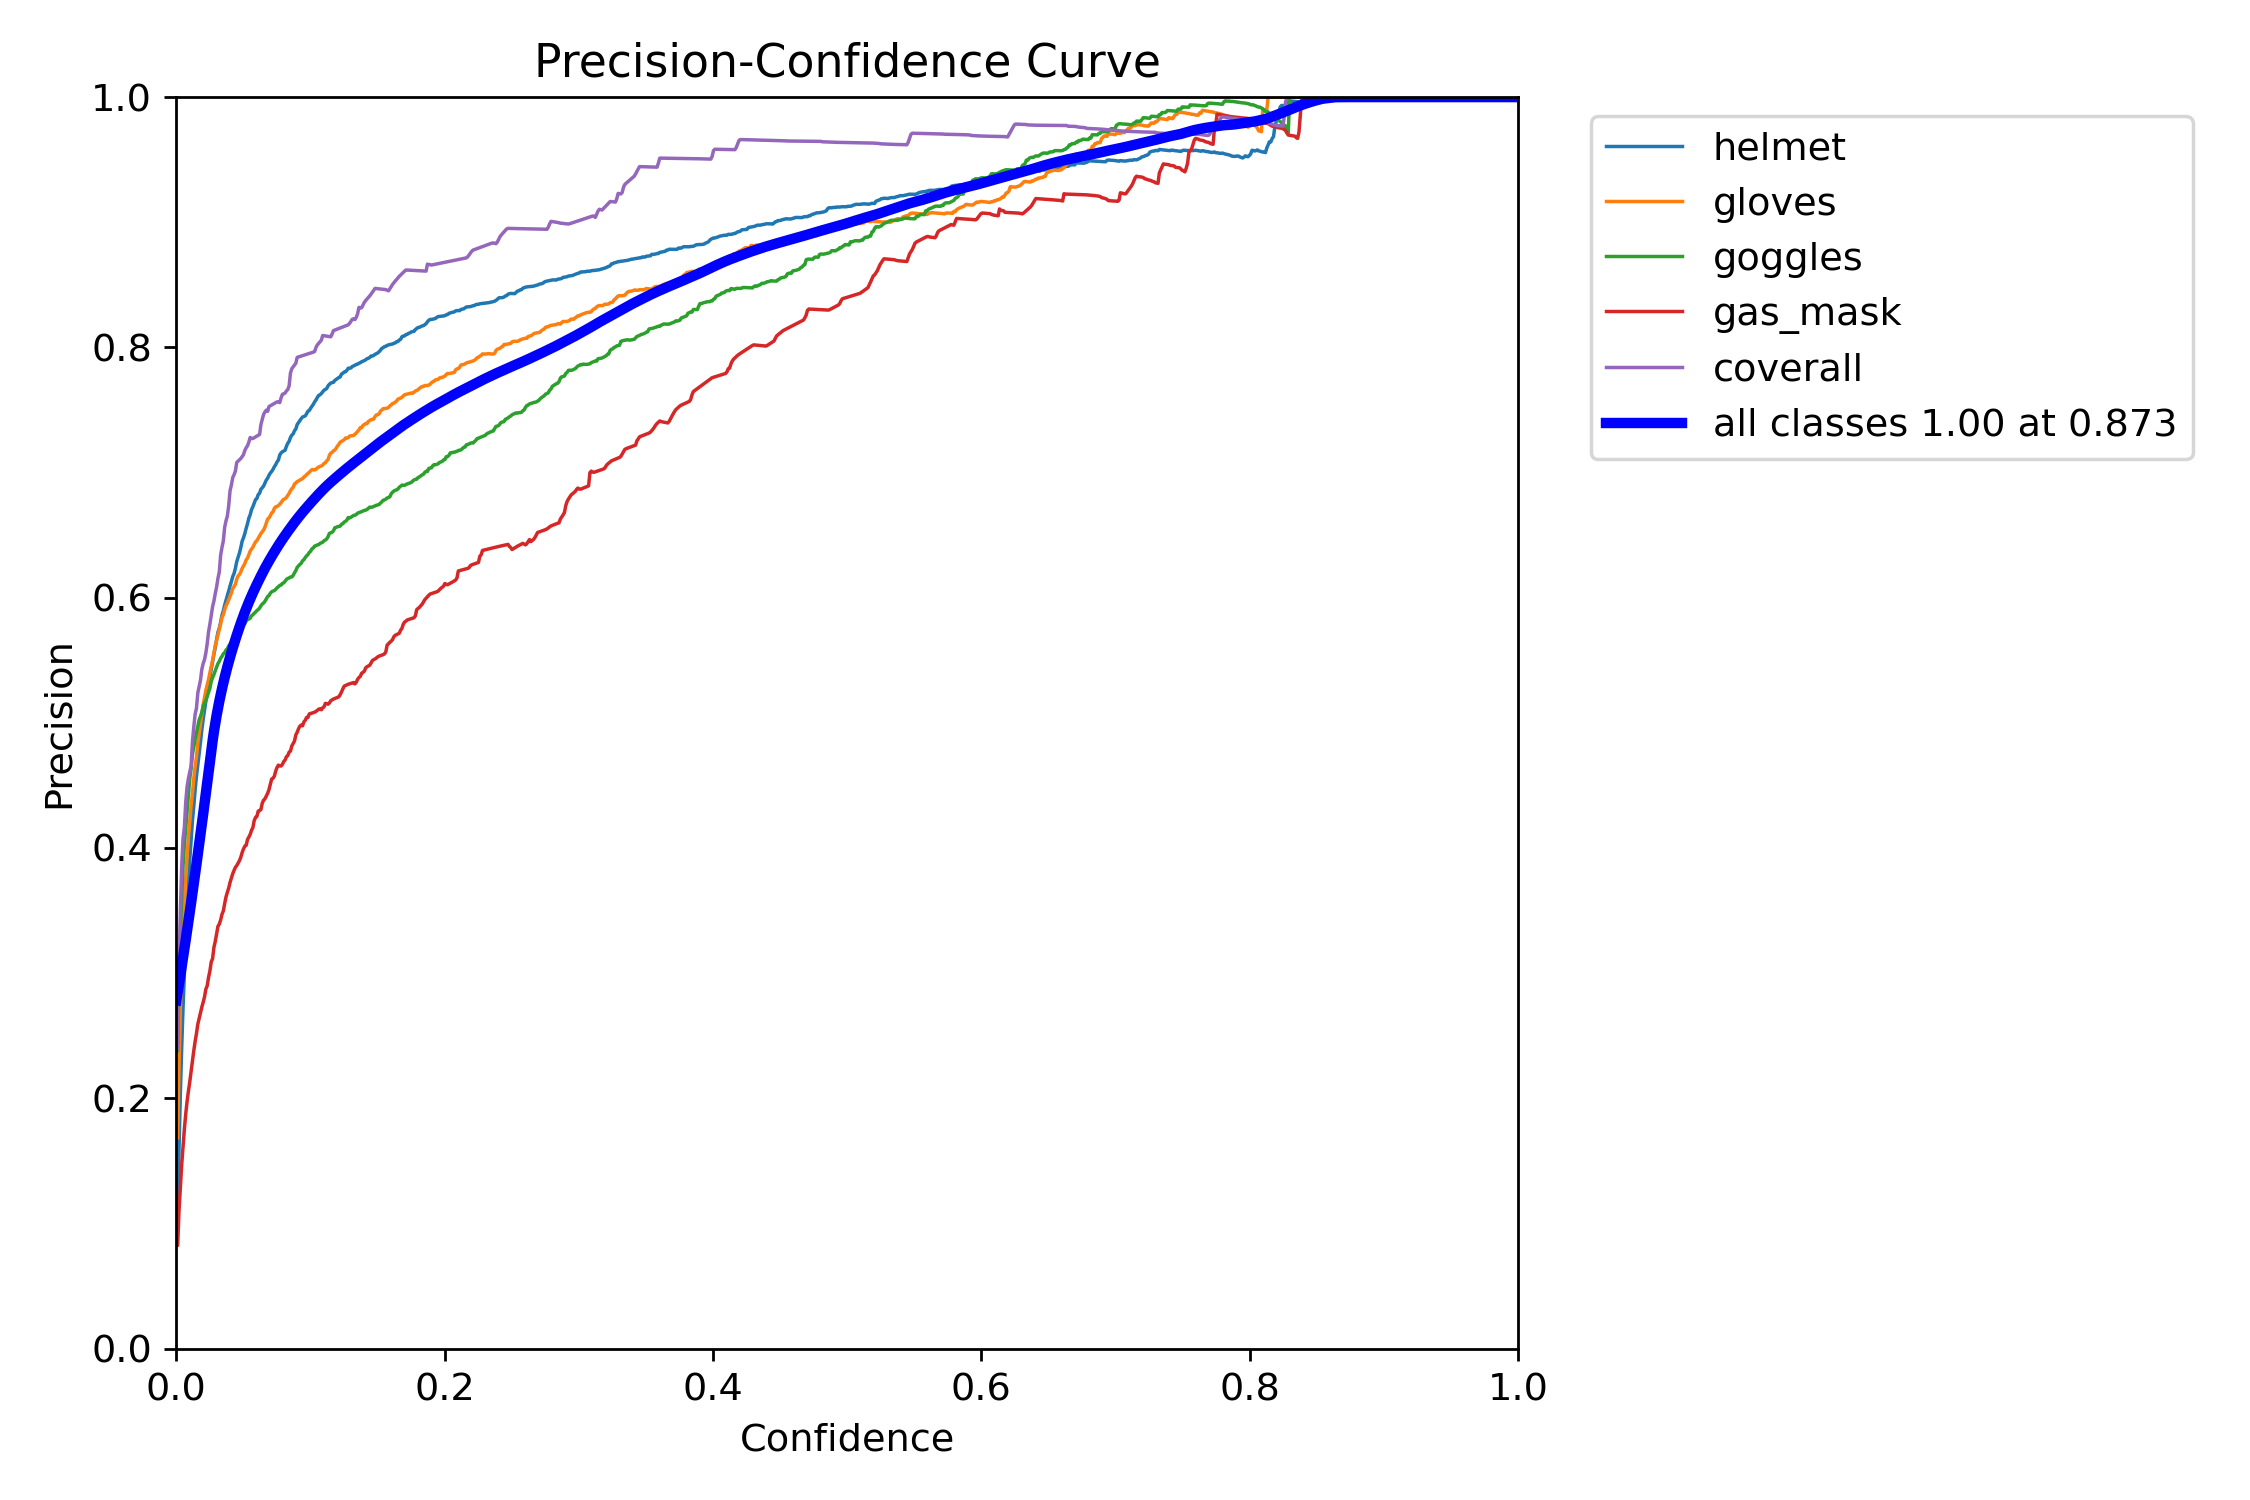

In [9]:
Image(filename=graph / 'P_curve.png', width=1000)

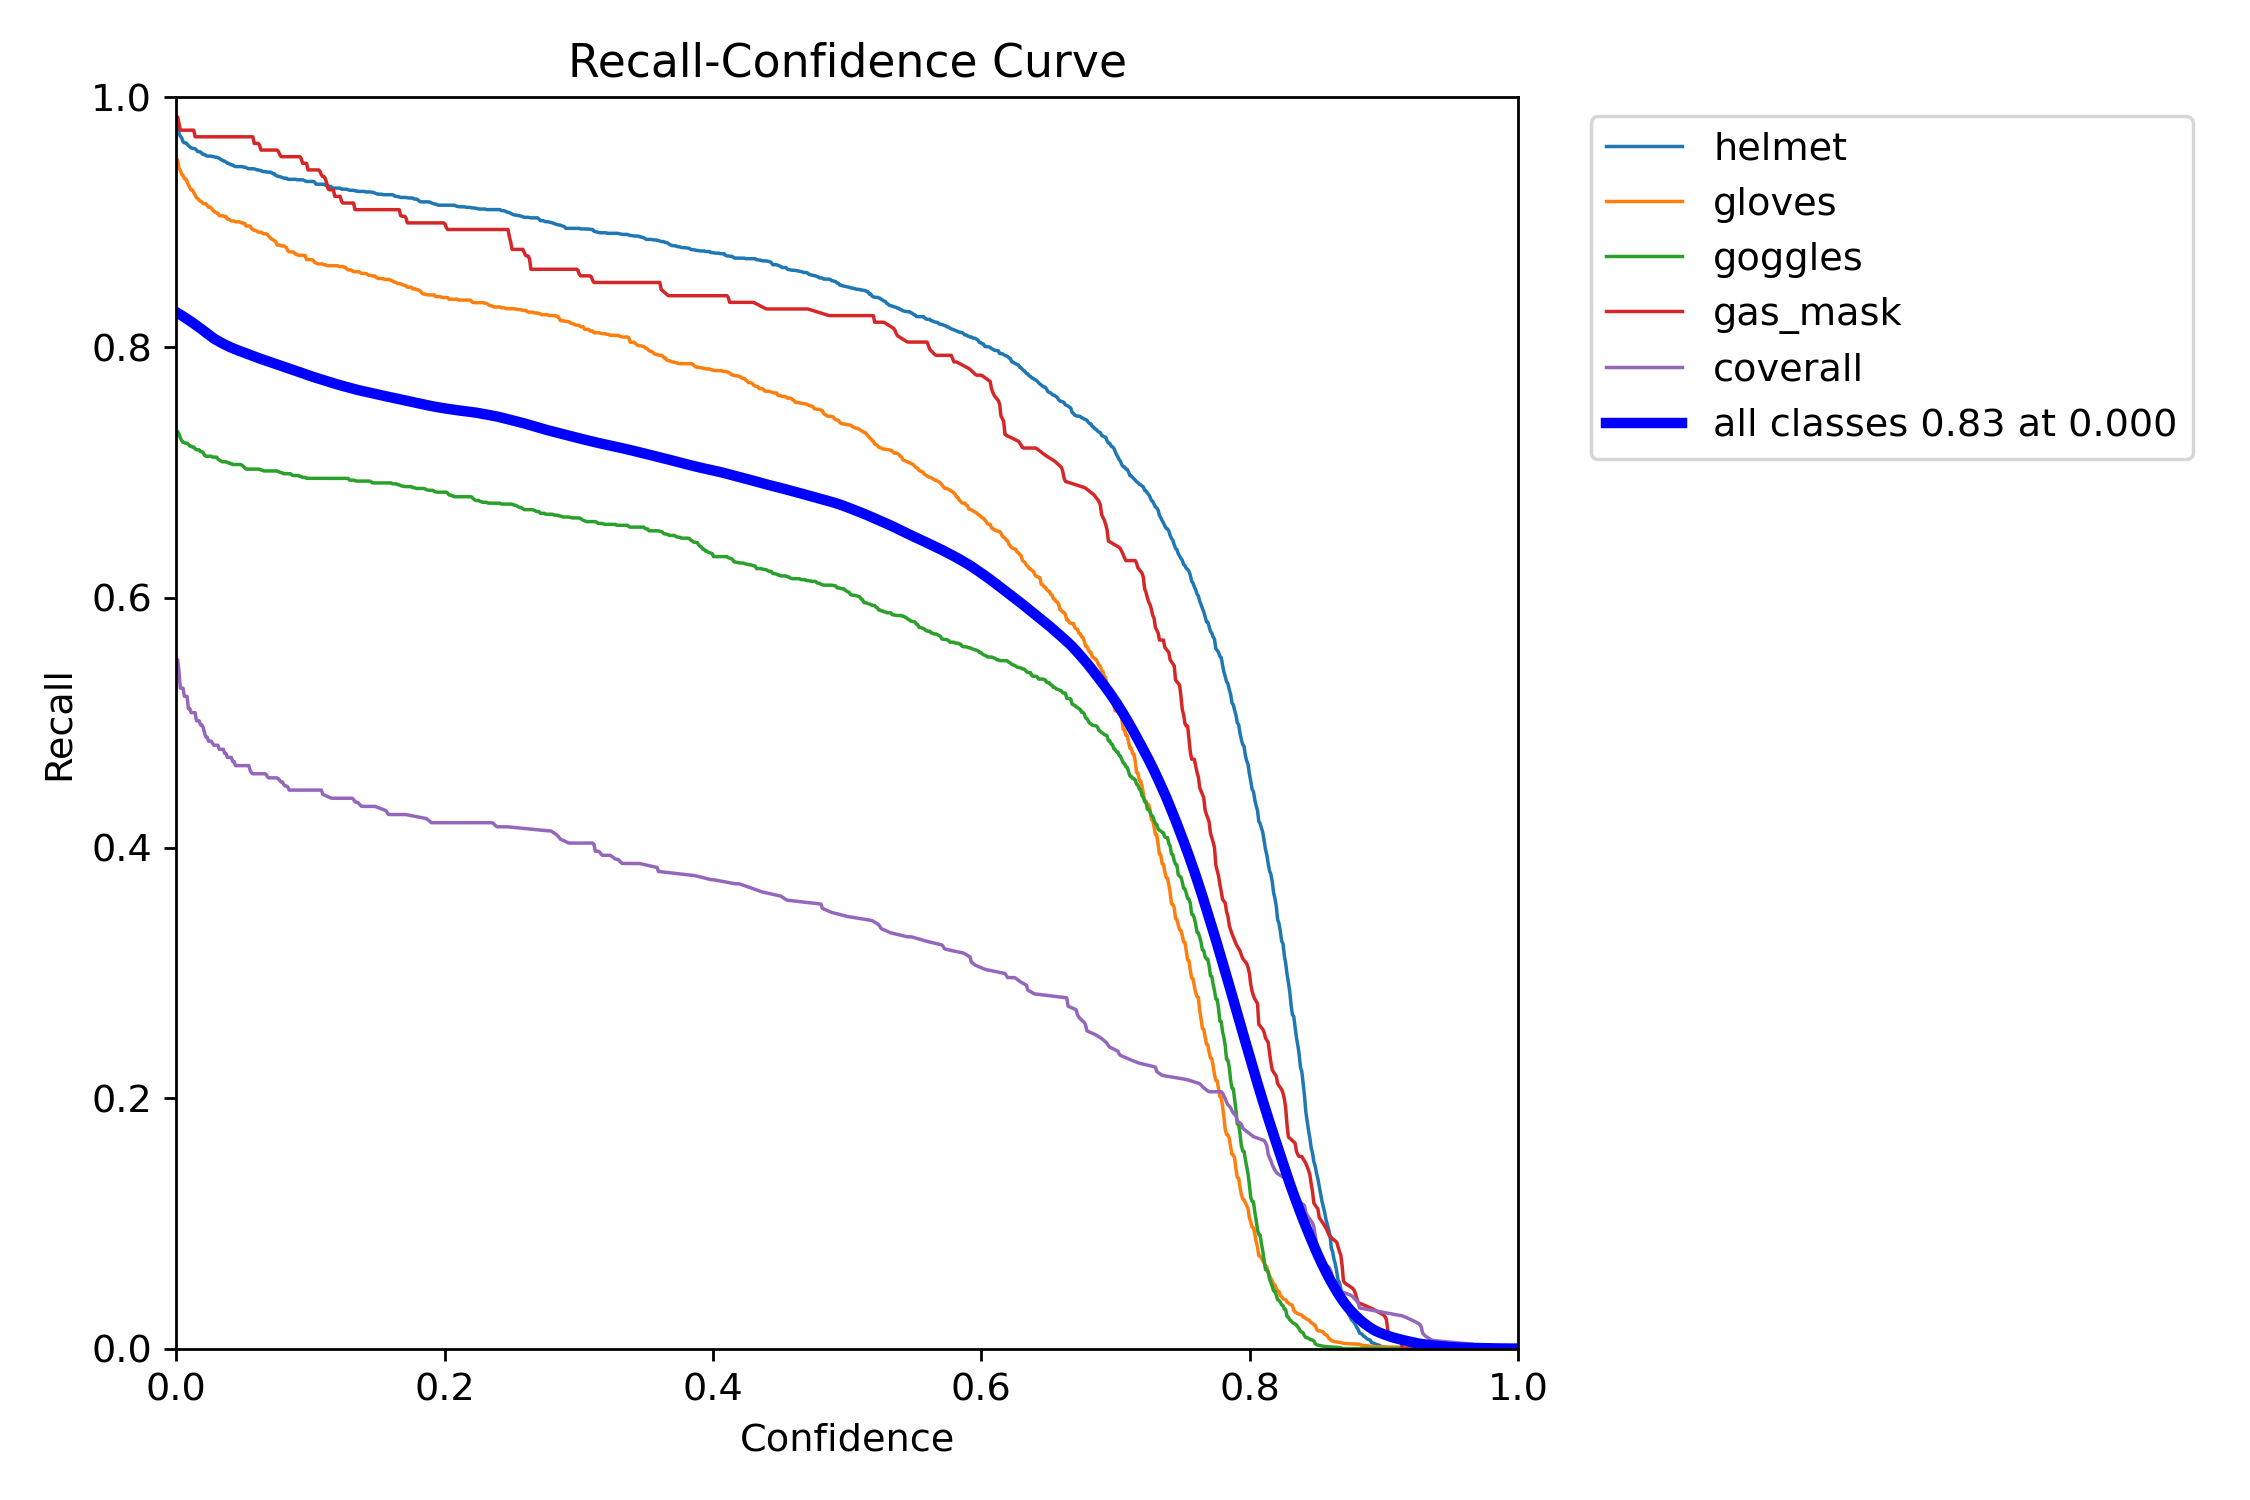

In [10]:
Image(filename=graph / 'R_curve.png', width=1000)

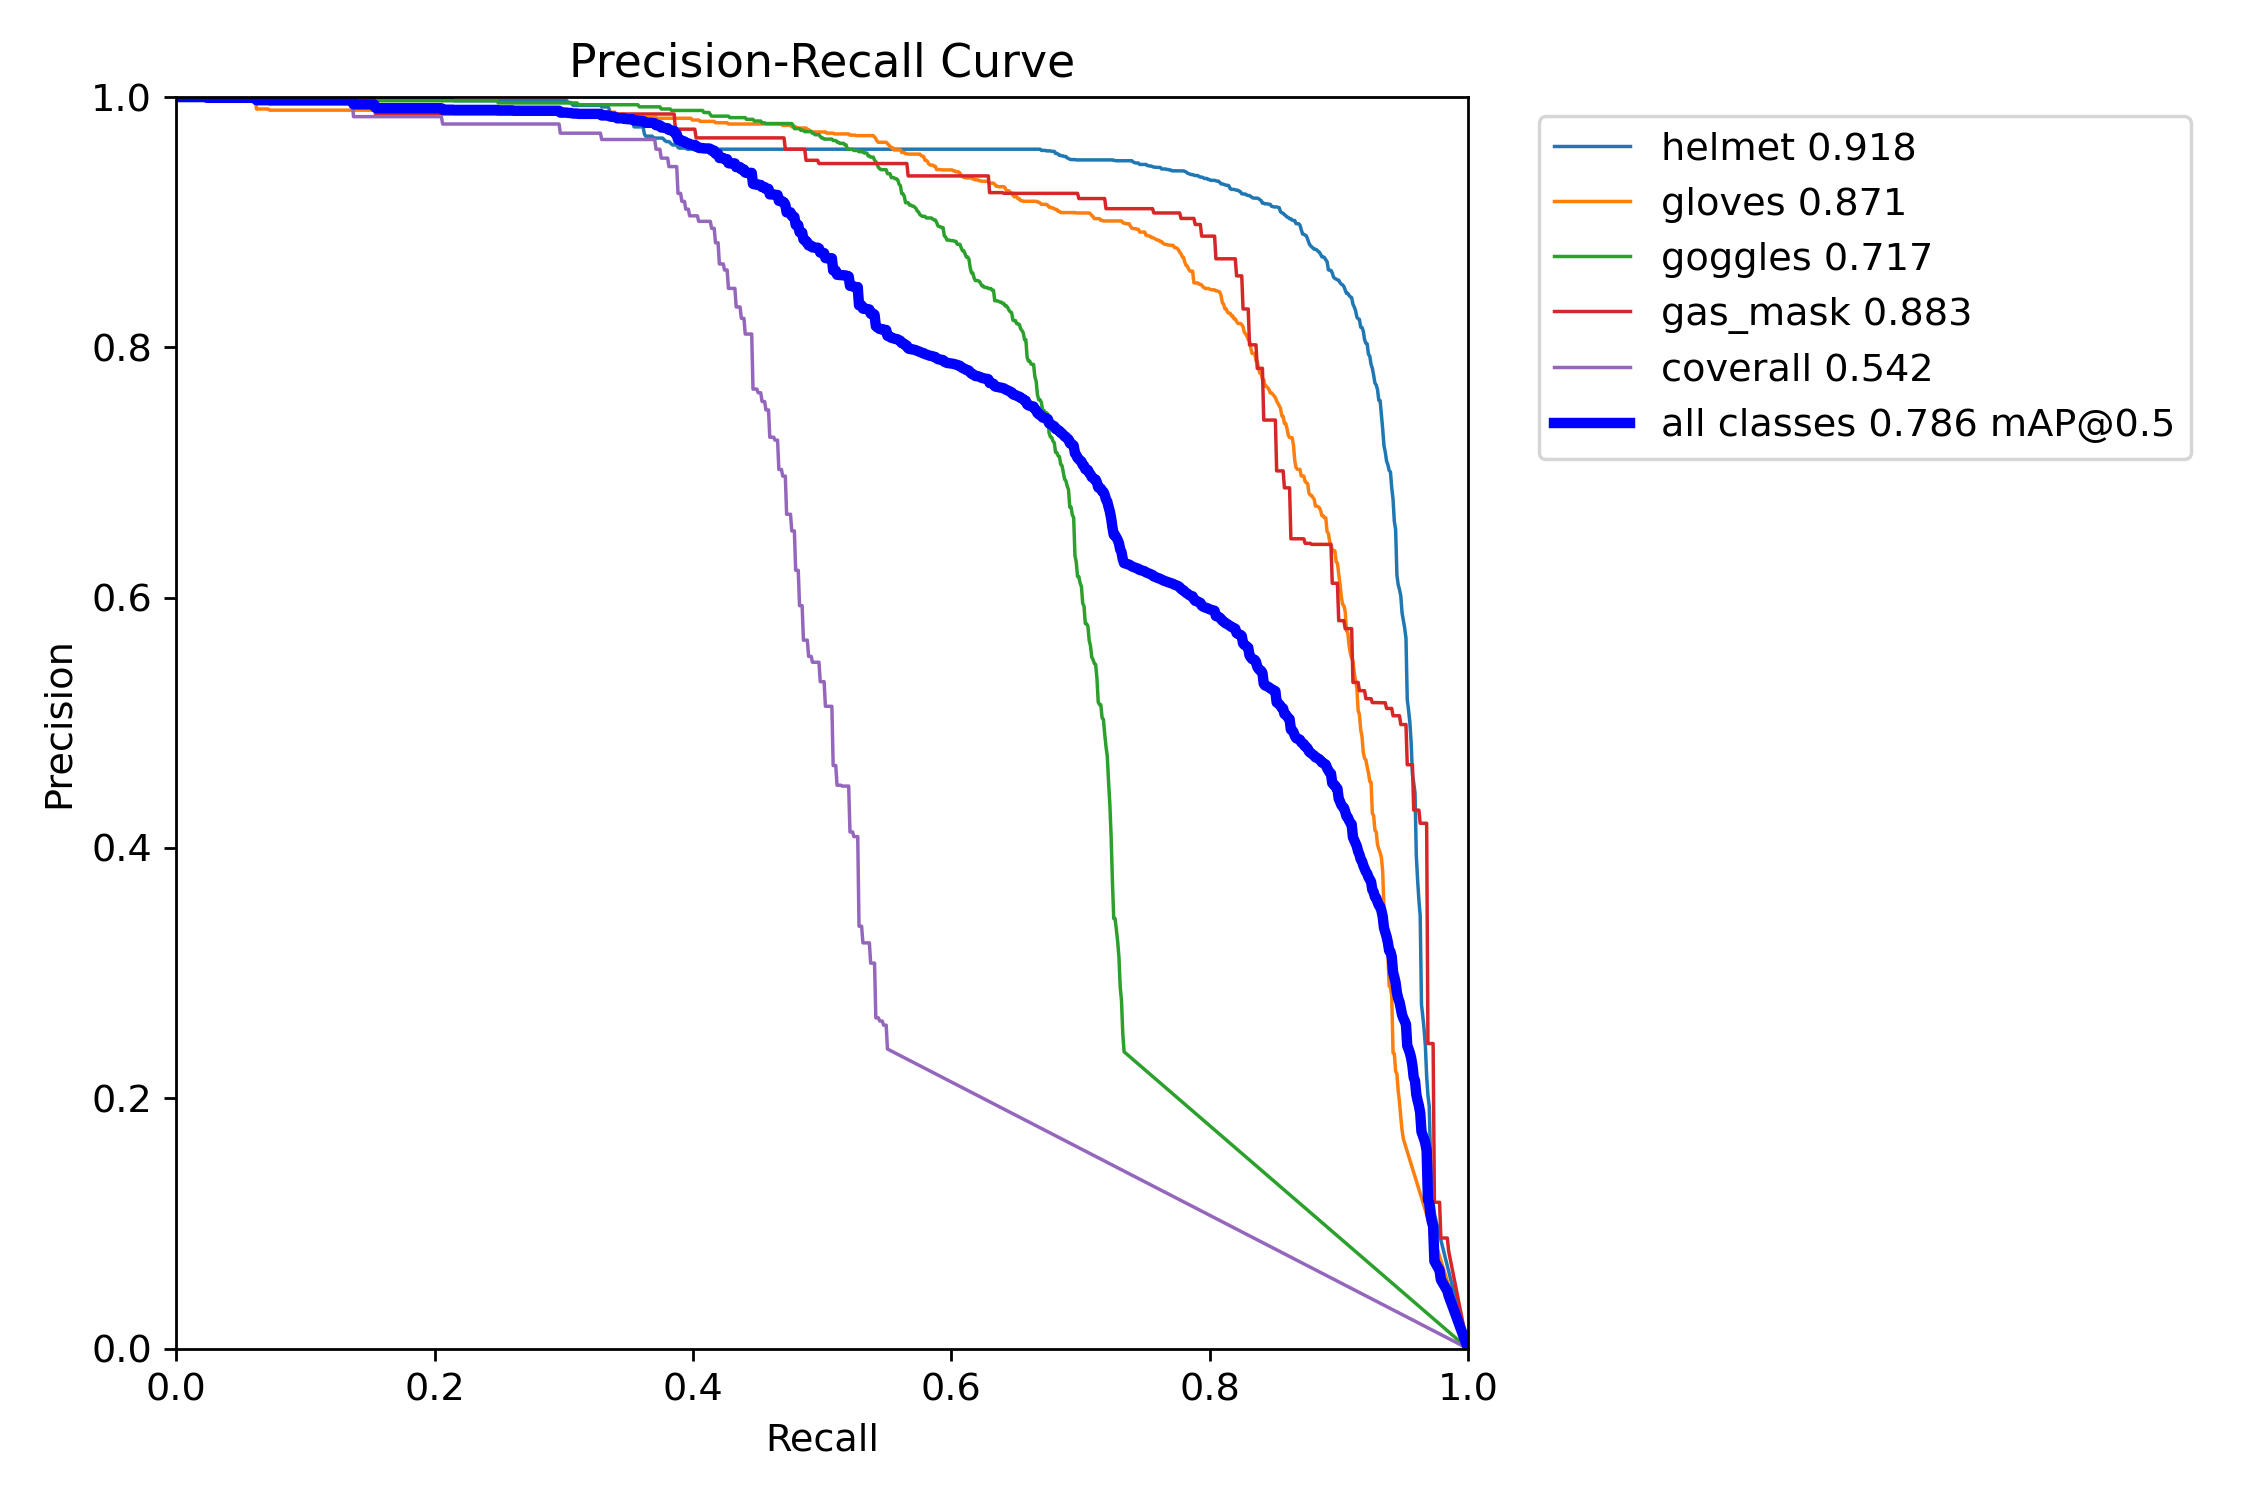

In [11]:
Image(filename=graph / 'PR_curve.png', width=1000)

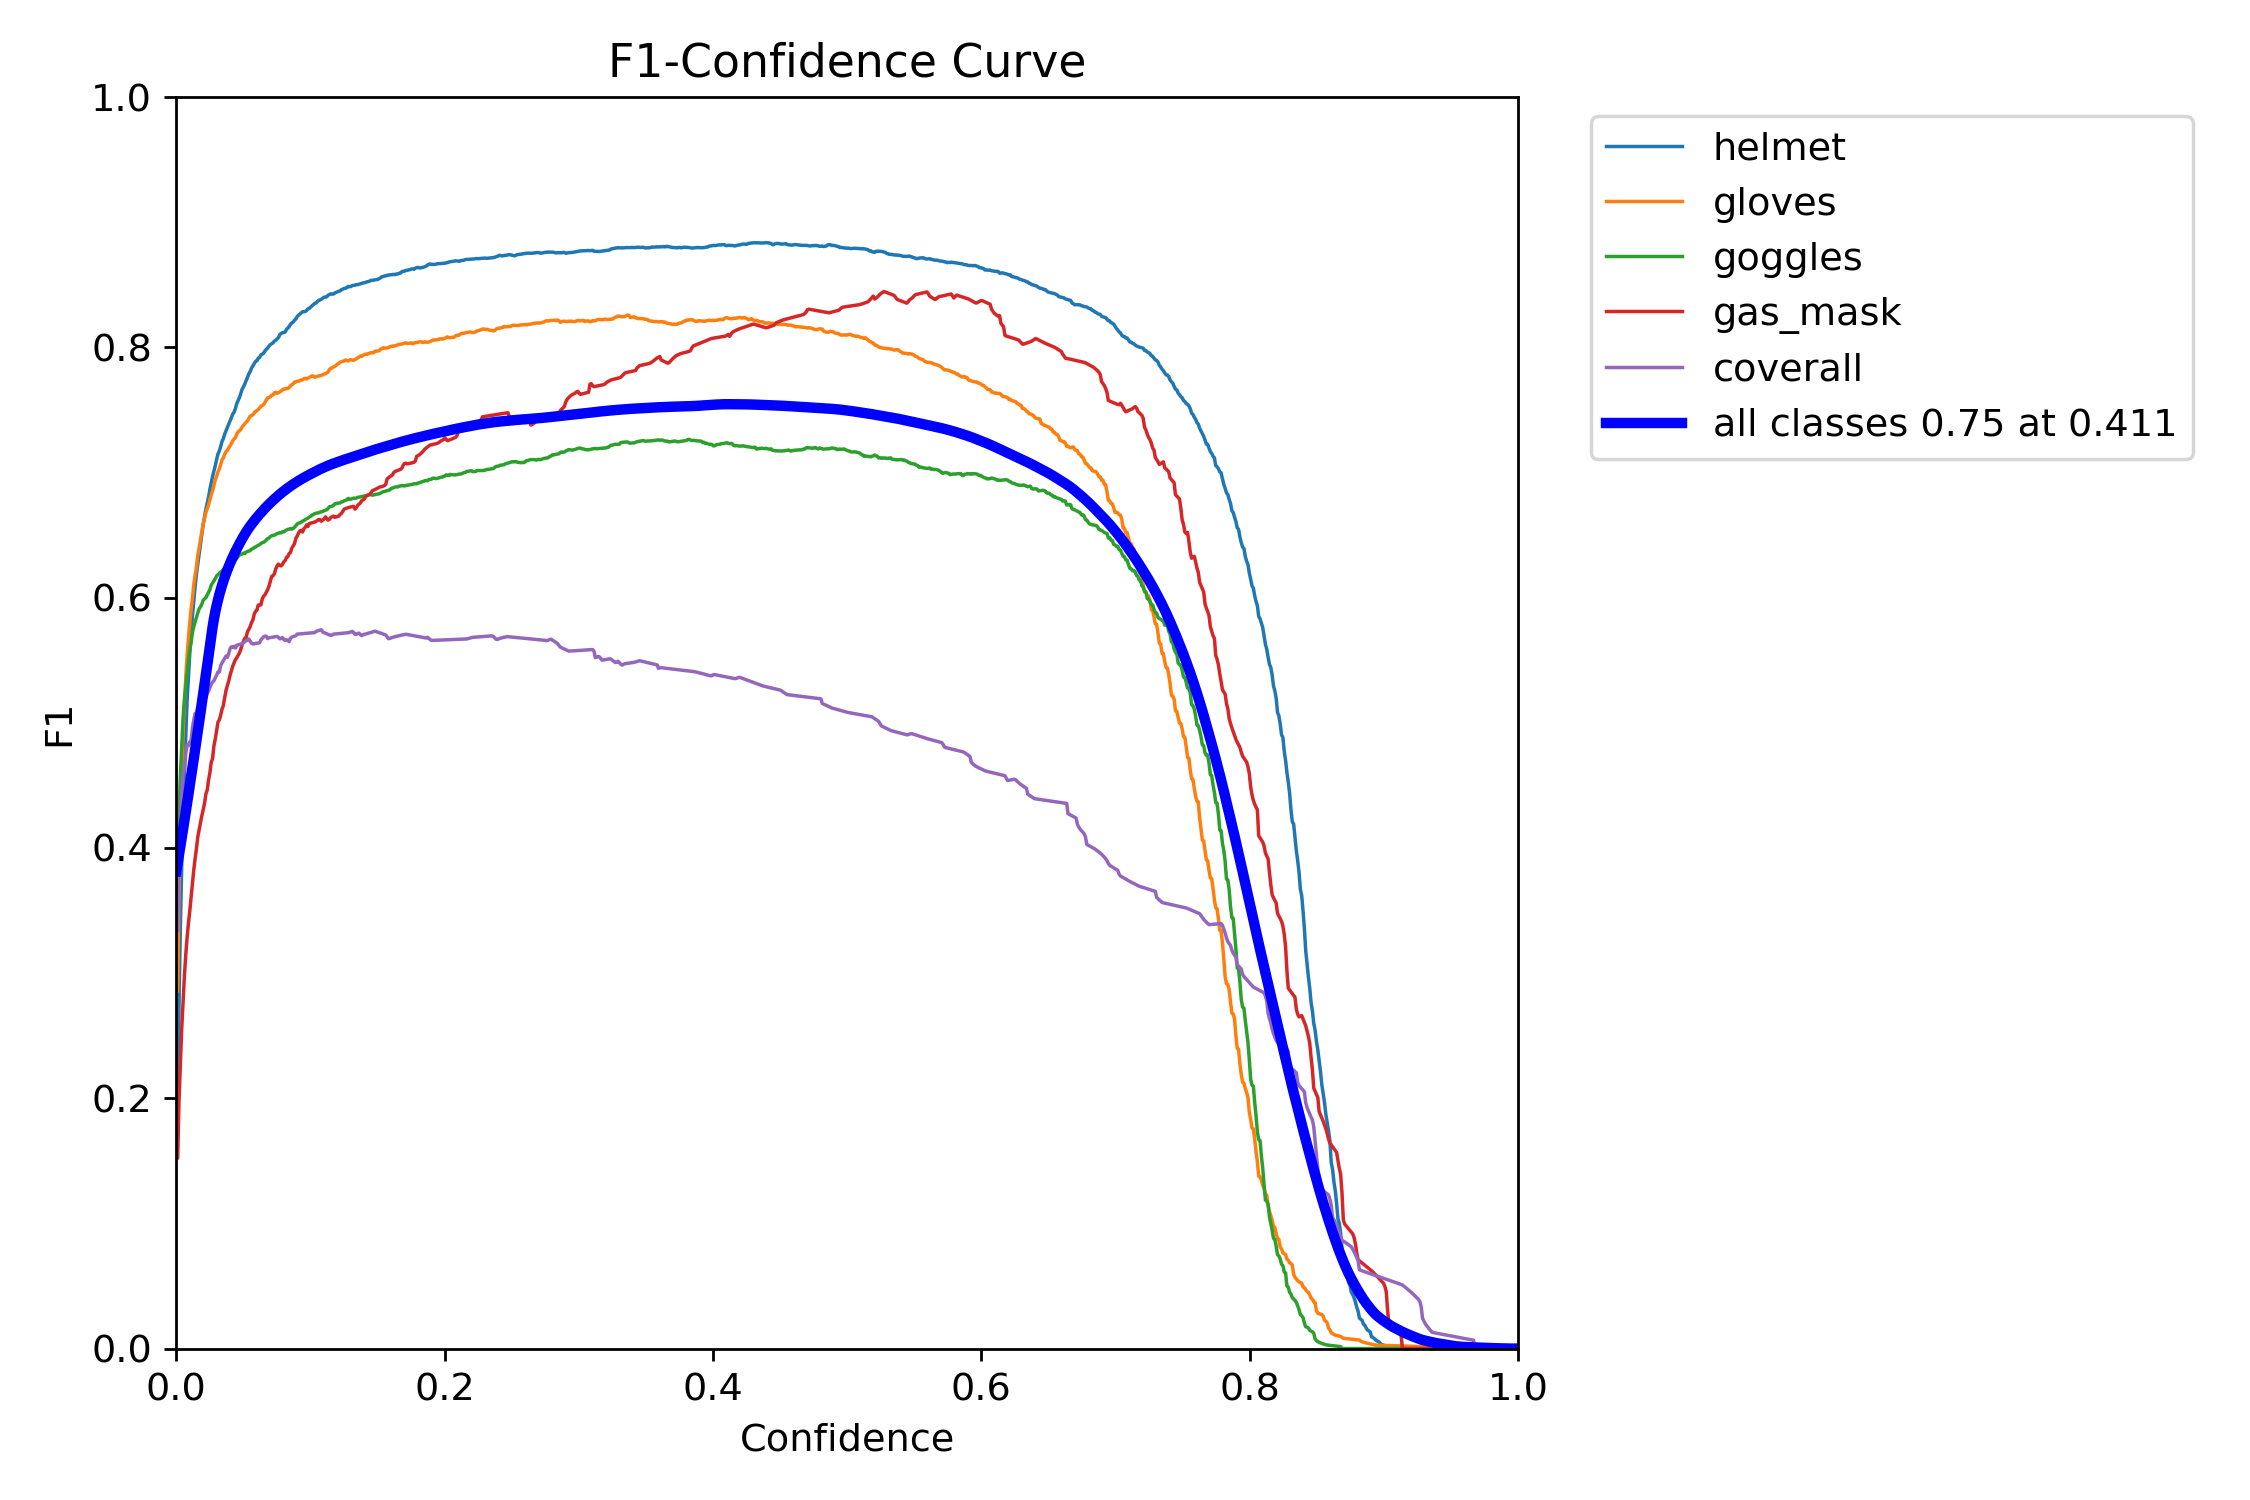

In [12]:
Image(filename=graph / 'F1_curve.png', width=1000)

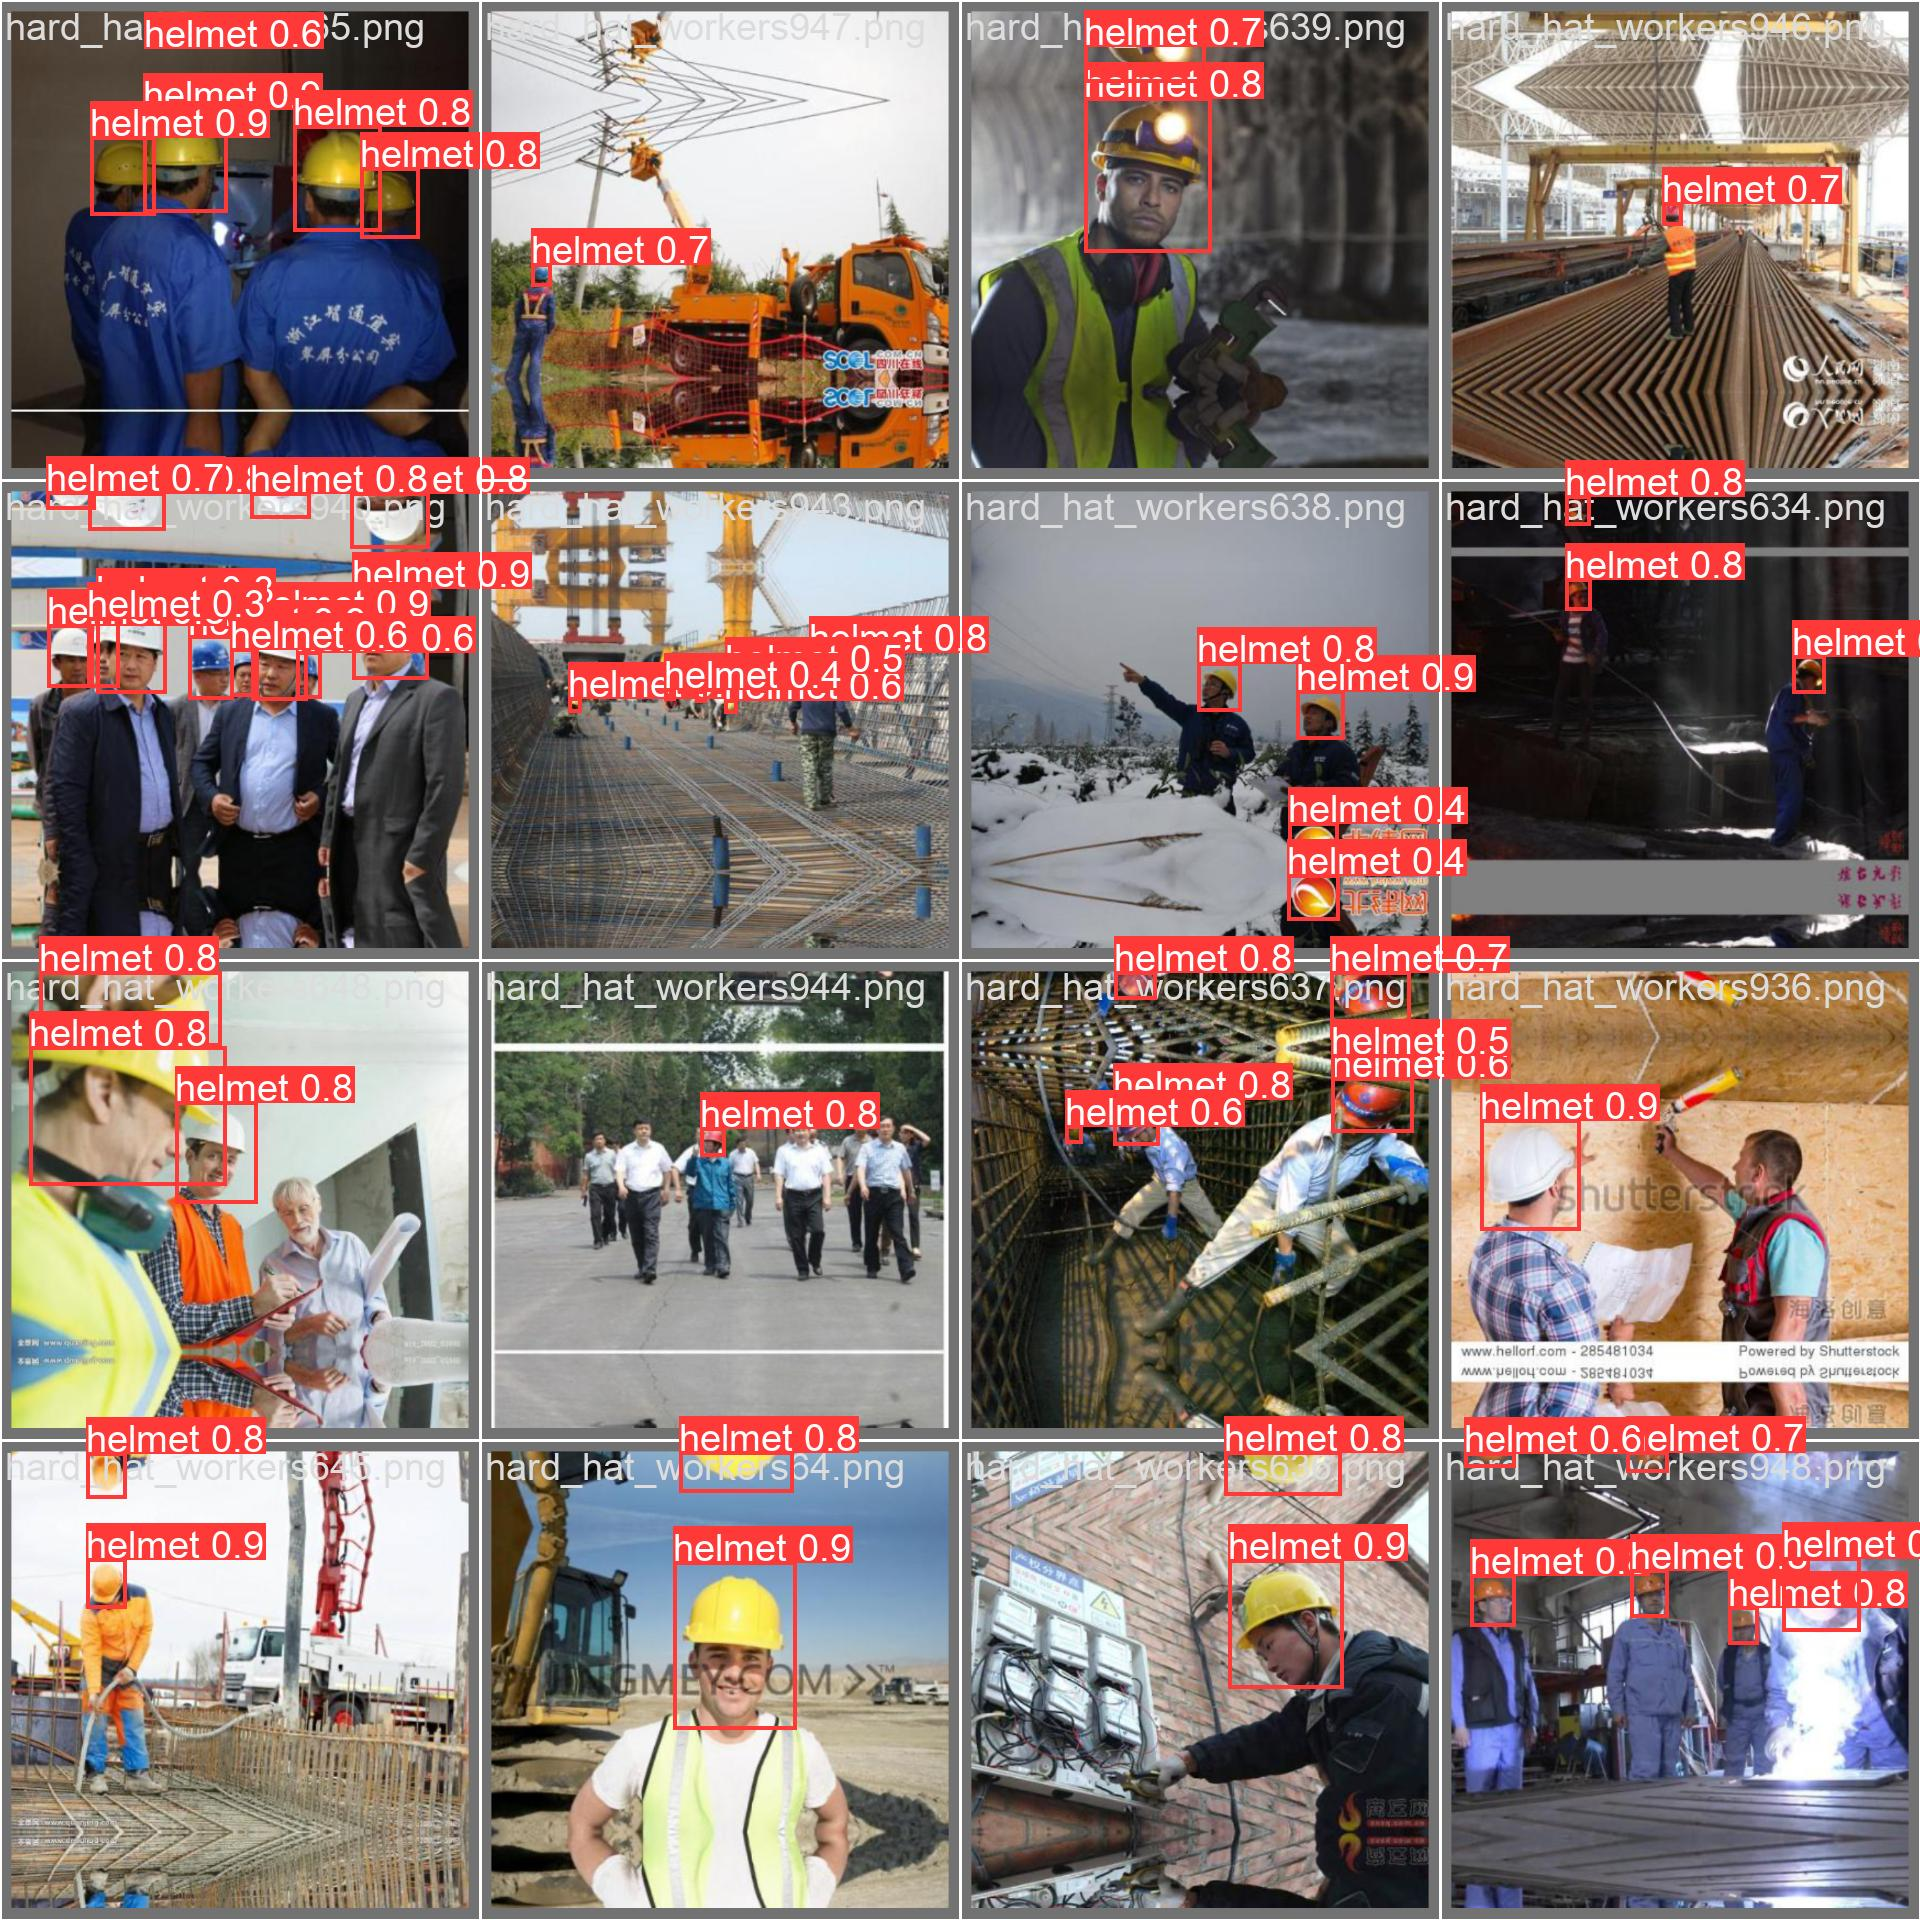

In [14]:
Image(filename=graph / 'val_batch2_pred.jpg', width=800)

In [17]:
model.export(format='engine', imgsz=640, half=True, dynamic=True, batch=16)
shutil.copy(graph / 'weights/best.engine', cwd / 'best.engine')

Ultralytics YOLOv8.2.28  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (16, 3, 640, 640) BCHW and output shape(s) (16, 9, 8400) (5.9 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success  3.0s, saved as 'runs\detect\train\weights\best.onnx' (11.5 MB)

TensorRT: starting export with TensorRT 10.0.1...
TensorRT: input "images" with shape(-1, 3, -1, -1) DataType.FLOAT
TensorRT: output "output0" with shape(-1, 9, -1) DataType.FLOAT
TensorRT: building FP16 engine as runs\detect\train\weights\best.engine
TensorRT: export success  326.0s, saved as 'runs\detect\train\weights\best.engine' (8.2 MB)

Export complete (326.4s)
Results saved to D:\Repos\ProtectionDetection\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.engine imgsz=640 

'runs\\detect\\train\\weights\\best.engine'